In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

In [8]:
funding = pd.read_csv(
    r"D:\Homework\QF634\project\Data\raw_funding_rate\BNBUSDT_funding_rate_20200101_20251130.csv",
    parse_dates=["fundingDateTime"],
    date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S.%f"),
)
funding = funding.sort_values("fundingDateTime")
funding = funding.rename(columns={"fundingDateTime": "timestamp", "fundingRate": "funding_rate"})
funding = funding.drop(columns=["symbol", "formattedFundingDateTime","markPrice"])
funding.set_index("timestamp", inplace=True)

spot = pd.read_json(
    r"D:\Homework\QF634\project\Data\raw_historical_price\BNBUSDT_5m_binance_spot_historical_data.json",
    lines=True,
).sort_values("timestamp").set_index("timestamp")

future = pd.read_json(
    r"D:\Homework\QF634\project\Data\raw_historical_price\BNBUSDT_5m_binance_futures_historical_data.json",
    lines=True,
).sort_values("timestamp").set_index("timestamp")

spot.index = pd.to_datetime(spot.index)
future.index = pd.to_datetime(future.index)
funding.index = pd.to_datetime(funding.index)

#Remove data from 15 mins before funding rate

fund_times = funding.index.sort_values()

clean_spot_windows = {}
clean_future_windows = {}

for i in range(1, len(fund_times)):
    t_prev = fund_times[i - 1]
    t_curr = fund_times[i]

    window_start = t_prev
    window_end = t_curr - pd.Timedelta(minutes=30)  # remove final 15m

    spot_window = spot.loc[(spot.index >= window_start) & (spot.index < window_end)]
    fut_window = future.loc[(future.index >= window_start) & (future.index < window_end)]

    clean_spot_windows[t_curr] = spot_window
    clean_future_windows[t_curr] = fut_window



C:\Users\timkf\AppData\Local\Temp\ipykernel_40724\1895134139.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  funding = pd.read_csv(


In [3]:
print(funding.shape)

(6360, 2)


In [9]:
#Feature Engineering

spot_rows = []
future_rows = []

for t in fund_times[1:]:  # skip first because no full window
    sw = clean_spot_windows[t]
    fw = clean_future_windows[t]

    # ---- Spot ----
    spot_rows.append(pd.Series({
        "spot_open": sw["open"].iloc[0] if len(sw) else np.nan,
        "spot_high": sw["high"].max() if len(sw) else np.nan,
        "spot_low": sw["low"].min() if len(sw) else np.nan,
        "spot_close": sw["close"].iloc[-1] if len(sw) else np.nan,
        "spot_volume": sw["volume"].sum() if len(sw) else 0.0,
        "spot_quote_volume": sw["quote_asset_volume"].sum() if len(sw) else 0.0,
        "spot_trades": sw["number_of_trades"].sum() if len(sw) else 0.0,
        "spot_taker_buy_base": sw["taker_buy_base_asset_volume"].sum() if len(sw) else 0.0,
        "spot_taker_buy_quote": sw["taker_buy_quote_asset_volume"].sum() if len(sw) else 0.0,
    }, name=t))

    # ---- Future ----
    future_rows.append(pd.Series({
        "fut_open": fw["open"].iloc[0] if len(fw) else np.nan,
        "fut_high": fw["high"].max() if len(fw) else np.nan,
        "fut_low": fw["low"].min() if len(fw) else np.nan,
        "fut_close": fw["close"].iloc[-1] if len(fw) else np.nan,
        "fut_volume": fw["volume"].sum() if len(fw) else 0.0,
        "fut_quote_volume": fw["quote_asset_volume"].sum() if len(fw) else 0.0,
        "fut_trades": fw["number_of_trades"].sum() if len(fw) else 0.0,
        "fut_taker_buy_base": fw["taker_buy_base_asset_volume"].sum() if len(fw) else 0.0,
        "fut_taker_buy_quote": fw["taker_buy_quote_asset_volume"].sum() if len(fw) else 0.0,
    }, name=t))

spot_8h = pd.DataFrame(spot_rows)
future_8h = pd.DataFrame(future_rows)

# ==========================================================
# 5. MERGE ALL 4H DATA
# ==========================================================
df = funding.merge(spot_8h, left_index=True, right_index=True, how="left") \
            .merge(future_8h, left_index=True, right_index=True, how="left")

# ----------------------------------------------------------
# ASSUME df has: 
# - funding_rate column
# - is_spike column (from classifier labeling)
# - all engineered features used for classifier
# ----------------------------------------------------------

FUNDING_COL = "funding_rate"   # change as needed

df = df.sort_index().copy()
df = df.dropna(subset=[FUNDING_COL])

# ======================================================
# 1. FUNDING LAG FEATURES
# ======================================================
lags = [1, 2, 3, 6, 12]   # 1 lag = 4 hours, 6 = 1 day, 12 = 2 days

for L in lags:
    df[f"funding_lag_{L}"] = df[FUNDING_COL].shift(L)

# ======================================================
# 2. FUNDING ROLLING WINDOWS (4h * N)
# ======================================================
df["funding_vol_3"] = df[FUNDING_COL].rolling(3, closed='left').std()
df["funding_vol_6"] = df[FUNDING_COL].rolling(6,closed='left').std()
df["funding_vol_12"] = df[FUNDING_COL].rolling(12, closed='left').std()

def rolling_max_drawdown_safe(series, window):
    s = series.shift(1)  # exclude current
    roll = s.rolling(window)
    return (roll.max() - s) / roll.max()

df["funding_mdd_6"]  = rolling_max_drawdown_safe(df[FUNDING_COL], 6).fillna(0)
df["funding_mdd_12"] = rolling_max_drawdown_safe(df[FUNDING_COL], 12).fillna(0)

# df["funding_mdd_6"] = mdd.fillna(0)
# ======================================================
# 3. BASIS FEATURES (future - spot)
# ======================================================
df["basis"] = df["fut_close"] - df["spot_close"]
df["basis_change"] = df["basis"] - df["basis"].shift(1)
df["basis_lag_1"] = df["basis"].shift(1)
df["basis_lag_3"] = df["basis"].shift(3)

# ======================================================
# 4. PRICE MOMENTUM (spot + future)
# ======================================================
for c in ["spot_close", "fut_close"]:
    df[f"{c}_ret_1"] = df[c].pct_change(1)
    df[f"{c}_ret_3"] = df[c].pct_change(3)
    df[f"{c}_ret_6"] = df[c].pct_change(6)

# ======================================================
# 5. PRICE VOLATILITY (spot + future)
# ======================================================
for c in ["spot_close", "fut_close"]:
    df[f"{c}_vol_3"] = df[c].pct_change().rolling(3).std()
    df[f"{c}_vol_6"] = df[c].pct_change().rolling(6).std()

# ======================================================
# 6. VOLUME PRESSURE FEATURES
# ======================================================
df["spot_buy_ratio"] = df["spot_taker_buy_base"] / (df["spot_volume"] + 1e-9)
df["fut_buy_ratio"]  = df["fut_taker_buy_base"] / (df["fut_volume"] + 1e-9)

df["spot_buy_ratio_lag1"] = df["spot_buy_ratio"].shift(1)
df["fut_buy_ratio_lag1"]  = df["fut_buy_ratio"].shift(1)

# ======================================================
# REMOVE ROWS WITH NAN FROM LAGS
# ======================================================
# df_prepared_features = df.dropna()
df_prepared_features = df

In [10]:
print(df_prepared_features.shape)
df.isna().sum().sort_values(ascending=False).head(20)

(6360, 47)


funding_vol_12        12
funding_lag_12        12
spot_close_ret_6       7
fut_close_ret_6        7
spot_close_vol_6       7
fut_close_vol_6        7
funding_lag_6          6
funding_vol_6          6
spot_close_vol_3       4
basis_lag_3            4
fut_close_vol_3        4
fut_close_ret_3        4
spot_close_ret_3       4
funding_vol_3          3
funding_lag_3          3
basis_change           2
fut_close_ret_1        2
basis_lag_1            2
spot_close_ret_1       2
fut_buy_ratio_lag1     2
dtype: int64

In [11]:
df_prepared_features = df.dropna()

In [13]:
#only predict spike

TARGET_COL = "funding_rate"   # change if needed

# Compute 90th percentile threshold on the FULL dataset (before train/test split)
p90 = df_prepared_features[TARGET_COL].quantile(0.80)

print(f"90th percentile funding rate threshold: {p90:.8f}")

# Option 1: keep only large POSITIVE funding rates
df_p90 = df[df[TARGET_COL] >= p90].copy()

# Option 2 (alternative): keep extreme magnitude regardless of sign
# p90_abs = df[TARGET_COL].abs().quantile(0.90)
# df_p90 = df[df[TARGET_COL].abs() >= p90_abs].copy()

print(f"Rows before filtering: {len(df)}")
print(f"Rows after filtering : {len(df_p90)}")

# (Recommended) Drop NaNs caused by lag/rolling features AFTER filtering
FEATURES = [
    "spot_open","spot_high","spot_low","spot_close","spot_volume","spot_quote_volume",
    "spot_trades","spot_taker_buy_base","spot_taker_buy_quote",
    "fut_open","fut_high","fut_low","fut_close","fut_volume","fut_quote_volume",
    "fut_trades","fut_taker_buy_base","fut_taker_buy_quote",
    "funding_lag_1","funding_lag_2","funding_lag_3","funding_lag_6","funding_lag_12",
    "funding_vol_3","funding_vol_6","funding_vol_12",
    "funding_mdd_6","funding_mdd_12",
    "basis","basis_change","basis_lag_1","basis_lag_3",
    "spot_close_ret_1","spot_close_ret_3","spot_close_ret_6",
    "fut_close_ret_1","fut_close_ret_3","fut_close_ret_6",
    "spot_close_vol_3","spot_close_vol_6","fut_close_vol_3","fut_close_vol_6",
    "spot_buy_ratio","fut_buy_ratio","spot_buy_ratio_lag1","fut_buy_ratio_lag1"
]

df_p90 = df_p90[FEATURES + [TARGET_COL]].dropna()

print(f"Rows after dropna   : {len(df_p90)}")


90th percentile funding rate threshold: 0.00005558
Rows before filtering: 6360
Rows after filtering : 1280
Rows after dropna   : 1270


In [14]:
from lightgbm import LGBMRegressor

features = [c for c in df.columns 
            if c not in ["timestamp","markPrice", FUNDING_COL]]

df = df_p90.sort_values("timestamp")

X = df[FEATURES]
y = df[TARGET_COL].astype(float)
# Determine split index
split_ratio = 0.7
split_index = int(len(df) * split_ratio)

# Time-based train-test split
train = df.iloc[:split_index]
test  = df.iloc[split_index:]

X_train = train[features]
y_train = train[FUNDING_COL]

X_test = test[features]
y_test = test[FUNDING_COL]

print(features)

['spot_open', 'spot_high', 'spot_low', 'spot_close', 'spot_volume', 'spot_quote_volume', 'spot_trades', 'spot_taker_buy_base', 'spot_taker_buy_quote', 'fut_open', 'fut_high', 'fut_low', 'fut_close', 'fut_volume', 'fut_quote_volume', 'fut_trades', 'fut_taker_buy_base', 'fut_taker_buy_quote', 'funding_lag_1', 'funding_lag_2', 'funding_lag_3', 'funding_lag_6', 'funding_lag_12', 'funding_vol_3', 'funding_vol_6', 'funding_vol_12', 'funding_mdd_6', 'funding_mdd_12', 'basis', 'basis_change', 'basis_lag_1', 'basis_lag_3', 'spot_close_ret_1', 'spot_close_ret_3', 'spot_close_ret_6', 'fut_close_ret_1', 'fut_close_ret_3', 'fut_close_ret_6', 'spot_close_vol_3', 'spot_close_vol_6', 'fut_close_vol_3', 'fut_close_vol_6', 'spot_buy_ratio', 'fut_buy_ratio', 'spot_buy_ratio_lag1', 'fut_buy_ratio_lag1']


In [15]:
model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.02,
    num_leaves=64,
    subsample=0.9,
    colsample_bytree=0.9
)

model.fit(X_train, y_train)

# -------------------------
# 7. Predict
# -------------------------
preds = model.predict(X_test)

# -------------------------
# 8. Evaluate
# -------------------------
mae = mean_absolute_error(y_test, preds)
print("MAE:", mae)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11557
[LightGBM] [Info] Number of data points in the train set: 889, number of used features: 46
[LightGBM] [Info] Start training from score 0.000557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

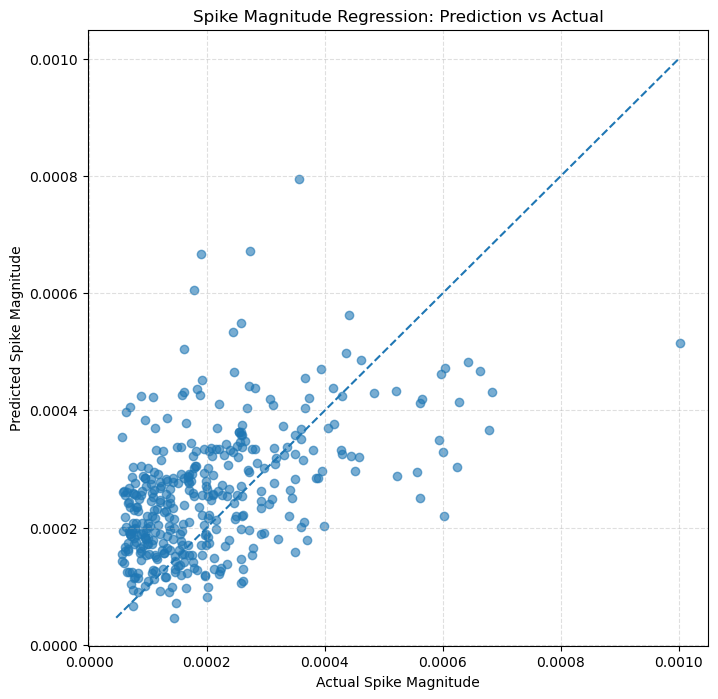

In [16]:
# Ensure arrays
y_true = np.array(y_test)
y_hat = np.array(preds)

plt.figure(figsize=(8, 8))

# Scatter points
plt.scatter(y_true, y_hat, alpha=0.6)

# Reference line (perfect prediction)
min_val = min(y_true.min(), y_hat.min())
max_val = max(y_true.max(), y_hat.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")

plt.xlabel("Actual Spike Magnitude")
plt.ylabel("Predicted Spike Magnitude")
plt.title("Spike Magnitude Regression: Prediction vs Actual")

plt.grid(True, linestyle="--", alpha=0.4)

In [17]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.02,
    depth=6,                 # ~ log2(64 leaves)
    subsample=0.9,
    rsm=0.9,                 # feature subsample (colsample_bytree)
    loss_function="MAE",
    random_seed=42,
    verbose=False
)

model.fit(X_train, y_train)

# -------------------------
# 7. Predict
# -------------------------
preds = model.predict(X_test)

# -------------------------
# 8. Evaluate
# -------------------------
mae = mean_absolute_error(y_test, preds)
print("MAE:", mae)



MAE: 8.040014127077884e-05


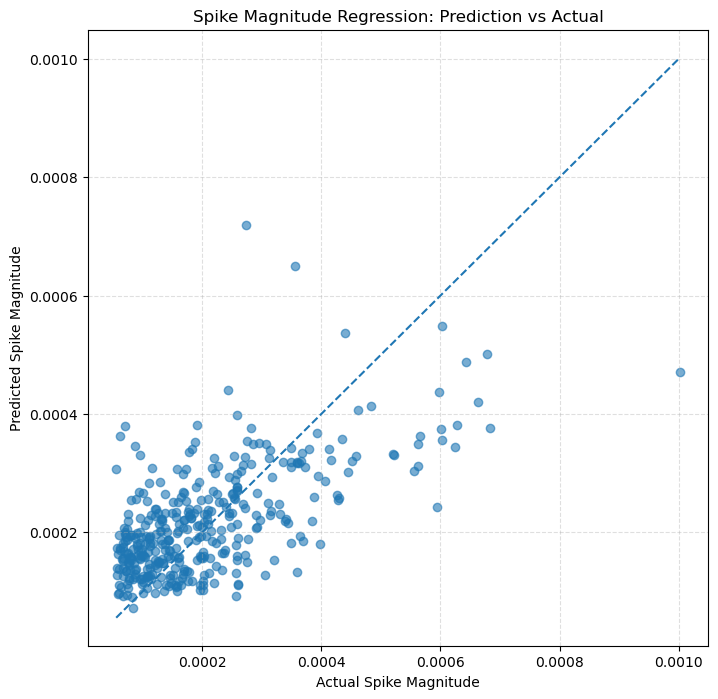

In [18]:
# Ensure arrays
y_true = np.array(y_test)
y_hat = np.array(preds)

plt.figure(figsize=(8, 8))

# Scatter points
plt.scatter(y_true, y_hat, alpha=0.6)

# Reference line (perfect prediction)
min_val = min(y_true.min(), y_hat.min())
max_val = max(y_true.max(), y_hat.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")

plt.xlabel("Actual Spike Magnitude")
plt.ylabel("Predicted Spike Magnitude")
plt.title("Spike Magnitude Regression: Prediction vs Actual")

plt.grid(True, linestyle="--", alpha=0.4)

In [19]:
print(X_train.shape)
print(y_train.shape)

(889, 46)
(889,)


In [20]:
RNN_FEATURES = [
    # Spot OHLCV
    "spot_open", "spot_high", "spot_low", "spot_close",
    "spot_volume", "spot_quote_volume", "spot_trades",
    "spot_taker_buy_base", "spot_taker_buy_quote",

    # Futures OHLCV
    "fut_open", "fut_high", "fut_low", "fut_close",
    "fut_volume", "fut_quote_volume", "fut_trades",
    "fut_taker_buy_base", "fut_taker_buy_quote",

    # Basis & order flow
    "basis",
    "spot_buy_ratio", "fut_buy_ratio",

    # Short-term returns
    "spot_close_ret_1",
    "fut_close_ret_1",
]

In [46]:
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# =========================
# Raw data
# =========================
X = df_prepared_features[RNN_FEATURES].values.astype(np.float32)
y = df_prepared_features[FUNDING_COL].values.astype(np.float32)
index = df_prepared_features.index

print("X shape:", X.shape)
print("y shape:", y.shape)

# =========================
# Train / test split
# =========================
TRAIN_RATIO = 0.7
split_raw = int(len(y) * TRAIN_RATIO)

X_train_raw = X[:split_raw]
X_test_raw  = X[split_raw:]

y_train_raw = y[:split_raw]
y_test_raw  = y[split_raw:]

index_train_raw = index[:split_raw]
index_test_raw  = index[split_raw:]

# =========================
# Spike definition (TRAIN ONLY)
# =========================
SPIKE_PCT = 80
spike_threshold = np.percentile(y_train_raw, SPIKE_PCT)

print(f"Spike threshold ({SPIKE_PCT}th pct): {spike_threshold:.6f}")

is_spike = y >= spike_threshold
is_spike_train = is_spike[:split_raw]
is_spike_test  = is_spike[split_raw:]

# =========================
# Scale X (train → test)
# =========================
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_raw)
X_test_scaled  = scaler_X.transform(X_test_raw)

# =========================
# Scale y (fit on TRAIN SPIKES ONLY)
# =========================
scaler_y = StandardScaler()

y_train_spike = y_train_raw[is_spike_train]

if len(y_train_spike) == 0:
    raise ValueError("No spike samples in training set — cannot fit y scaler.")

scaler_y.fit(y_train_spike.reshape(-1, 1))

y_train_scaled = scaler_y.transform(y_train_raw.reshape(-1, 1)).flatten()
y_test_scaled  = scaler_y.transform(y_test_raw.reshape(-1, 1)).flatten()

# =========================
# Sequence construction
# =========================
LOOKBACK = 12

def make_sequences(X, y, index, lookback):
    X_seq, y_seq, idx_seq = [], [], []
    for i in range(lookback, len(X)):
        X_seq.append(X[i - lookback:i])
        y_seq.append(y[i])
        idx_seq.append(index[i])
    return (
        np.array(X_seq, dtype=np.float32),
        np.array(y_seq, dtype=np.float32),
        np.array(idx_seq)
    )

X_train_seq, y_train_seq, idx_train_seq = make_sequences(
    X_train_scaled,
    y_train_scaled,
    index_train_raw,
    LOOKBACK
)

X_test_seq, y_test_seq, idx_test_seq = make_sequences(
    X_test_scaled,
    y_test_scaled,
    index_test_raw,
    LOOKBACK
)

# =========================
# Align spike mask with sequences
# =========================
is_spike_train_seq = is_spike_train[LOOKBACK:]
is_spike_test_seq  = is_spike_test[LOOKBACK:]

# =========================
# Keep ONLY spike samples
# =========================
X_train_spike = X_train_seq[is_spike_train_seq]
y_train_spike = y_train_seq[is_spike_train_seq]
idx_train_spike = idx_train_seq[is_spike_train_seq]

X_test_spike = X_test_seq[is_spike_test_seq]
y_test_spike = y_test_seq[is_spike_test_seq]
idx_test_spike = idx_test_seq[is_spike_test_seq]

print("Spike train samples:", len(X_train_spike))
print("Spike test samples :", len(X_test_spike))
print("X_train_spike shape:", X_train_spike.shape)

if len(X_train_spike) == 0:
    raise ValueError("No spike sequences available for training.")

# =========================
# Model
# =========================
model = Sequential([
    SimpleRNN(
        64,
        activation="tanh",
        input_shape=(LOOKBACK, X_train_spike.shape[2])
    ),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

es = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

# =========================
# Train
# =========================
model.fit(
    X_train_spike,
    y_train_spike,
    validation_split=0.1,
    epochs=200,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

X shape: (6348, 23)
y shape: (6348,)
Spike threshold (80th pct): 0.000095
Spike train samples: 882
Spike test samples : 223
X_train_spike shape: (882, 12, 23)
Epoch 1/200


c:\Users\timkf\anaconda3\envs\QF634_project\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2163 - mae: 0.7860 - val_loss: 0.2188 - val_mae: 0.3667
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0161 - mae: 0.7256 - val_loss: 0.1204 - val_mae: 0.2662
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9067 - mae: 0.6888 - val_loss: 0.0974 - val_mae: 0.2389
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8310 - mae: 0.6549 - val_loss: 0.1752 - val_mae: 0.3448
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7666 - mae: 0.6333 - val_loss: 0.1156 - val_mae: 0.2619
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7690 - mae: 0.6333 - val_loss: 0.1086 - val_mae: 0.2540
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7233 - mae: 0.6126 - val_loss: 0.1636 - val_mae: 0.3026
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7205 - mae: 0.6079 - val_loss: 0.1659 - val_mae: 0.3073
Epoch 9/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6527 - mae: 0.5

In [48]:
# =========================
# Predict on test spikes
# =========================
y_test_pred_scaled = model.predict(X_test_spike).flatten()

# Inverse scale back to original funding-rate space
y_test_pred = scaler_y.inverse_transform(
    y_test_pred_scaled.reshape(-1, 1)
).flatten()

y_test_true = scaler_y.inverse_transform(
    y_test_spike.reshape(-1, 1)
).flatten()

# =========================
# Build comparison DataFrame
# =========================
pred_df = pd.DataFrame(
    {
        "y_true": y_test_true,
        "y_pred": y_test_pred,
    },
    index=idx_test_spike
)

print(pred_df.head())
print(pred_df.describe())

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
                           y_true    y_pred
2024-03-10 16:00:00.000  0.000363  0.000660
2024-03-12 00:00:00.000  0.000197  0.000357
2024-03-12 08:00:00.000  0.000555  0.000585
2024-03-13 00:00:00.000  0.000349  0.000449
2024-03-13 08:00:00.001  0.000643  0.000378
           y_true      y_pred
count  223.000000  223.000000
mean     0.000212    0.000442
std      0.000104    0.000124
min      0.000096    0.000043
25%      0.000133    0.000354
50%      0.000190    0.000449
75%      0.000258    0.000534
max      0.000677    0.000722


In [49]:
mae = mean_absolute_error(y_test_true, y_test_pred)
print("MAE:", mae)

MAE: 0.00024587821098975837


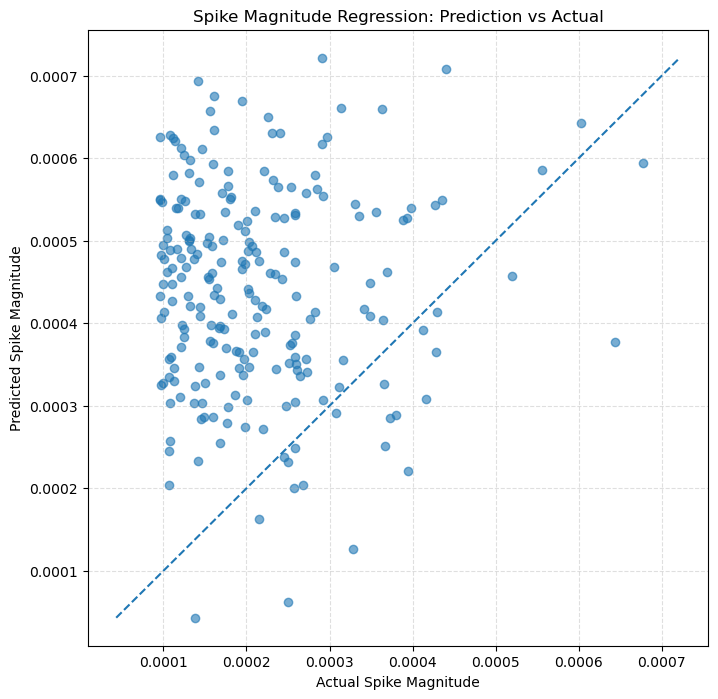

In [50]:
y_true = np.array(y_test_true)
y_hat = np.array(y_test_pred)

plt.figure(figsize=(8, 8))

# Scatter points
plt.scatter(y_true, y_hat, alpha=0.6)

# Reference line (perfect prediction)
min_val = min(y_true.min(), y_hat.min())
max_val = max(y_true.max(), y_hat.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")

plt.xlabel("Actual Spike Magnitude")
plt.ylabel("Predicted Spike Magnitude")
plt.title("Spike Magnitude Regression: Prediction vs Actual")

plt.grid(True, linestyle="--", alpha=0.4)

In [137]:
import numpy as np
import tensorflow as tf
import pandas as pd

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# =========================
# Raw data
# =========================
X = df_prepared_features[RNN_FEATURES].values.astype(np.float32)
y = df_prepared_features[FUNDING_COL].values.astype(np.float32)
index = df_prepared_features.index

print("X shape:", X.shape)
print("y shape:", y.shape)

# =========================
# Train / test split
# =========================
TRAIN_RATIO = 0.7
split_raw = int(len(y) * TRAIN_RATIO)

X_train_raw = X[:split_raw]
X_test_raw  = X[split_raw:]

y_train_raw = y[:split_raw]
y_test_raw  = y[split_raw:]

index_train_raw = index[:split_raw]
index_test_raw  = index[split_raw:]

# =========================
# Spike definition (TRAIN ONLY)
# =========================
SPIKE_PCT = 80
tau = np.percentile(y_train_raw, SPIKE_PCT)

print(f"Spike threshold ({SPIKE_PCT}th pct): {tau:.6f}")

is_spike = y >= tau
is_spike_train = is_spike[:split_raw]
is_spike_test  = is_spike[split_raw:]

# =========================
# Scale X (train → test)
# =========================
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_raw)
X_test_scaled  = scaler_X.transform(X_test_raw)

# =========================
# Sequence construction (RAW y)
# =========================
LOOKBACK = 12

def make_sequences(X, y, index, lookback):
    X_seq, y_seq, idx_seq = [], [], []
    for i in range(lookback, len(X)):
        X_seq.append(X[i - lookback:i])
        y_seq.append(y[i])
        idx_seq.append(index[i])
    return (
        np.array(X_seq, dtype=np.float32),
        np.array(y_seq, dtype=np.float32),
        np.array(idx_seq)
    )

X_train_seq, y_train_seq_raw, idx_train_seq = make_sequences(
    X_train_scaled,
    y_train_raw,
    index_train_raw,
    LOOKBACK
)

X_test_seq, y_test_seq_raw, idx_test_seq = make_sequences(
    X_test_scaled,
    y_test_raw,
    index_test_raw,
    LOOKBACK
)

# =========================
# Align spike mask with sequences
# =========================
is_spike_train_seq = is_spike_train[LOOKBACK:]
is_spike_test_seq  = is_spike_test[LOOKBACK:]

# =========================
# Keep ONLY spike samples (stage-2)
# =========================
X_train_spike = X_train_seq[is_spike_train_seq]
y_train_spike = y_train_seq_raw[is_spike_train_seq]
idx_train_spike = idx_train_seq[is_spike_train_seq]

X_test_spike = X_test_seq[is_spike_test_seq]
y_test_spike = y_test_seq_raw[is_spike_test_seq]
idx_test_spike = idx_test_seq[is_spike_test_seq]

print("Spike train samples:", len(X_train_spike))
print("Spike test samples :", len(X_test_spike))

if len(X_train_spike) == 0:
    raise ValueError("No spike samples for stage-2 training.")

# =====================================================
# FIX 1: log1p(excess / scale) TARGET
# =====================================================
EPS = 1e-8

# excess over threshold
train_excess = y_train_spike - tau
test_excess  = y_test_spike - tau

# scale = median excess (robust, stable)
scale = np.median(train_excess[train_excess > 0])

print(f"Log-excess scale: {scale:.6e}")

# log1p target (stable, bounded)
y_train_target = np.log1p(train_excess / scale).astype(np.float32)
y_test_target  = np.log1p(test_excess  / scale).astype(np.float32)

# =========================
# Quantile loss
# =========================
quantile_weights = {
    0.1: 0.05,
    0.3: 0.10,
    0.5: 0.35,
    0.7: 0.25,
    0.9: 0.15,
    0.95: 0.10}
QUANTILES = list(quantile_weights.keys())

class QuantileLoss(tf.keras.losses.Loss):
    def __init__(self, quantiles, name="quantile_loss"):
        super().__init__(name=name)
        self.quantiles = tf.constant(quantiles, dtype=tf.float32)

    def call(self, y_true, y_pred):
        y_true = tf.expand_dims(y_true, axis=-1)
        error = y_true - y_pred
        return tf.reduce_mean(
            tf.maximum(
                self.quantiles * error,
                (self.quantiles - 1.0) * error
            )
        )

# =========================
# Model (multi-quantile)
# =========================
model = Sequential([
    SimpleRNN(
        128,
        activation="tanh",
        input_shape=(LOOKBACK, X_train_spike.shape[2])
    ),
    # Dropout(0.2),
    Dense(len(QUANTILES))
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=QuantileLoss(QUANTILES)
)

es = EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True
)

# =========================
# Train
# =========================
model.fit(
    X_train_spike,
    y_train_target,
    validation_split=0.1,
    epochs=300,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

# =========================
# Predict & inverse transform (SAFE)
# =========================
y_test_pred_target_q = model.predict(X_test_spike)

# inverse: funding rate space
y_test_pred_q = tau + scale * np.expm1(y_test_pred_target_q)

# =========================
# Build prediction DataFrame
# =========================
pred_df = pd.DataFrame(
    y_test_pred_q,
    columns=QUANTILES,
    index=idx_test_spike
)
pred_df["y_true"] = y_test_spike

print(pred_df.head())

X shape: (6348, 23)
y shape: (6348,)
Spike threshold (80th pct): 0.000095
Spike train samples: 882
Spike test samples : 223
Log-excess scale: 2.922319e-04
Epoch 1/300


c:\Users\timkf\anaconda3\envs\QF634_project\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2406 - val_loss: 0.2043
Epoch 2/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1434 - val_loss: 0.1268
Epoch 3/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1346 - val_loss: 0.1299
Epoch 4/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1223 - val_loss: 0.1246
Epoch 5/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1190 - val_loss: 0.1285
Epoch 6/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1143 - val_loss: 0.1341
Epoch 7/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1148 - val_loss: 0.1143
Epoch 8/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1068 - val_loss: 0.1066
Epoch 9/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1090 - val_loss: 0.1060
Epoch 10/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1052 - val_loss: 0.1138
Epoch 11/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1016 - val_loss: 0.1142
Epoch 12/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0997 - val_lo

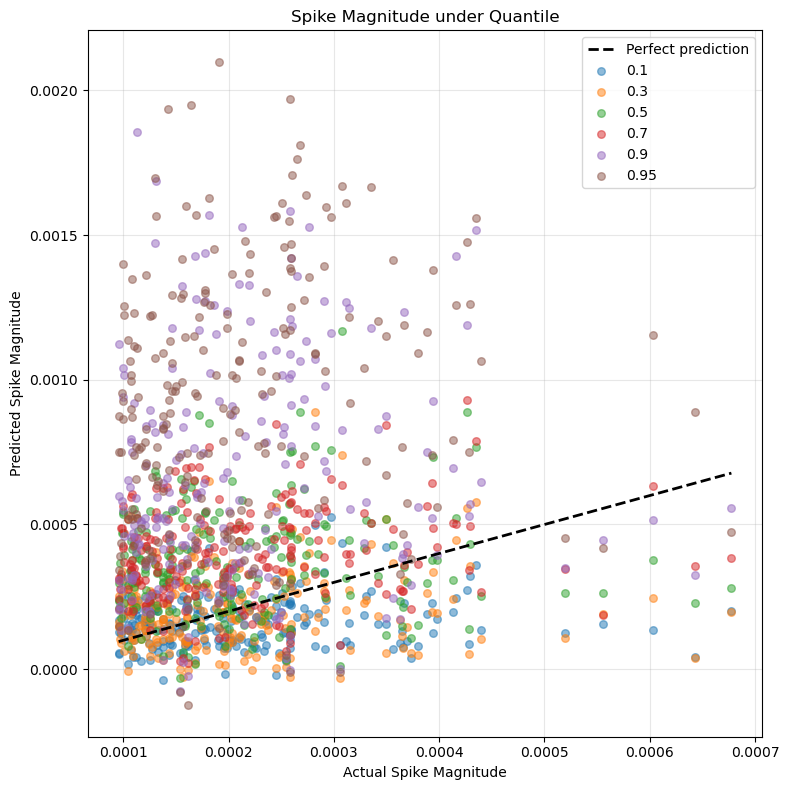

In [138]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

# Reference diagonal
min_y = pred_df["y_true"].min()
max_y = pred_df["y_true"].max()

plt.plot(
    [min_y, max_y],
    [min_y, max_y],
    linestyle="--",
    linewidth=2,
    color="black",
    label="Perfect prediction"
)

#QUANTILES = [0.5, 0.75, 0.9, 0.95]
columns = QUANTILES

# Plot each quantile
for q in columns:
    plt.scatter(
        pred_df["y_true"],
        pred_df[q],
        alpha=0.5,
        s=30,
        label=q
    )

plt.xlabel("Actual Spike Magnitude")
plt.ylabel("Predicted Spike Magnitude")
plt.title("Spike Magnitude under Quantile")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [139]:
from scipy.stats import spearmanr

for q in QUANTILES:
    rho, _ = spearmanr(pred_df["y_true"], pred_df[q])
    print(f"Spearman ρ ({q}): {rho:.3f}")

Spearman ρ (0.1): 0.083
Spearman ρ (0.3): 0.146
Spearman ρ (0.5): 0.062
Spearman ρ (0.7): 0.159
Spearman ρ (0.9): 0.183
Spearman ρ (0.95): 0.195


In [140]:
import numpy as np

# sanity check
assert abs(sum(quantile_weights.values()) - 1.0) < 1e-6

weight_sum = sum(quantile_weights.values())
if not np.isclose(weight_sum, 1.0):
    raise ValueError(f"Quantile weights must sum to 1. Got {weight_sum}")

pred_df["expected_spike_given_spike"] = sum(
    w * pred_df[q] for q, w in quantile_weights.items()
)

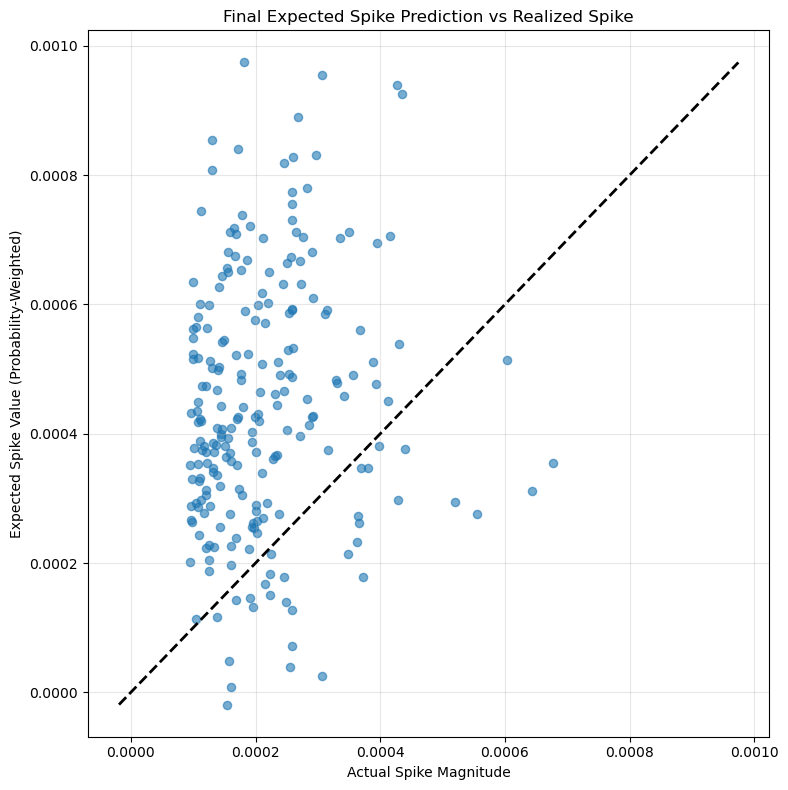

In [141]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

# Reference diagonal
min_y = min(
    pred_df["expected_spike_given_spike"].min(),
    pred_df["y_true"].min()
)
max_y = max(
    pred_df["expected_spike_given_spike"].max(),
    pred_df["y_true"].max()
)

plt.plot(
    [min_y, max_y],
    [min_y, max_y],
    linestyle="--",
    linewidth=2,
    color="black",
    label="Perfect prediction"
)

# Scatter plot
plt.scatter(
    pred_df["y_true"],
    pred_df["expected_spike_given_spike"],
    alpha=0.6,
    s=35
)

plt.xlabel("Actual Spike Magnitude")
plt.ylabel("Expected Spike Value (Probability-Weighted)")
plt.title("Final Expected Spike Prediction vs Realized Spike")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [66]:
#only predict spike

TARGET_COL = "funding_rate"   # change if needed

# Compute 90th percentile threshold on the FULL dataset (before train/test split)
p90 = df_prepared_features[TARGET_COL].quantile(0.80)

print(f"90th percentile funding rate threshold: {p90:.8f}")

# Option 1: keep only large POSITIVE funding rates
df_p90 = df[df[TARGET_COL] >= p90].copy()

# Option 2 (alternative): keep extreme magnitude regardless of sign
# p90_abs = df[TARGET_COL].abs().quantile(0.90)
# df_p90 = df[df[TARGET_COL].abs() >= p90_abs].copy()

print(f"Rows before filtering: {len(df)}")
print(f"Rows after filtering : {len(df_p90)}")

# (Recommended) Drop NaNs caused by lag/rolling features AFTER filtering
FEATURES = [
    "spot_open","spot_high","spot_low","spot_close","spot_volume","spot_quote_volume",
    "spot_trades","spot_taker_buy_base","spot_taker_buy_quote",
    "fut_open","fut_high","fut_low","fut_close","fut_volume","fut_quote_volume",
    "fut_trades","fut_taker_buy_base","fut_taker_buy_quote",
    "funding_lag_1","funding_lag_2","funding_lag_3","funding_lag_6","funding_lag_12",
    "funding_vol_3","funding_vol_6","funding_vol_12",
    "funding_mdd_6","funding_mdd_12",
    "basis","basis_change","basis_lag_1","basis_lag_3",
    "spot_close_ret_1","spot_close_ret_3","spot_close_ret_6",
    "fut_close_ret_1","fut_close_ret_3","fut_close_ret_6",
    "spot_close_vol_3","spot_close_vol_6","fut_close_vol_3","fut_close_vol_6",
    "spot_buy_ratio","fut_buy_ratio","spot_buy_ratio_lag1","fut_buy_ratio_lag1"
]

df_p90 = df_p90[FEATURES + [TARGET_COL]].dropna()

print(f"Rows after dropna   : {len(df_p90)}")

90th percentile funding rate threshold: 0.00005558
Rows before filtering: 1270
Rows after filtering : 1270
Rows after dropna   : 1270


In [67]:
features = [c for c in df.columns 
            if c not in ["timestamp","markPrice", FUNDING_COL]]

df = df_p90.sort_values("timestamp")

X = df[FEATURES]
y = df[TARGET_COL].astype(float)
# Determine split index
split_ratio = 0.7
split_index = int(len(df) * split_ratio)

# Time-based train-test split
train = df.iloc[:split_index]
test  = df.iloc[split_index:]

X_train = train[features]
y_train = train[FUNDING_COL]

X_test = test[features]
y_test = test[FUNDING_COL]

print(features)

['spot_open', 'spot_high', 'spot_low', 'spot_close', 'spot_volume', 'spot_quote_volume', 'spot_trades', 'spot_taker_buy_base', 'spot_taker_buy_quote', 'fut_open', 'fut_high', 'fut_low', 'fut_close', 'fut_volume', 'fut_quote_volume', 'fut_trades', 'fut_taker_buy_base', 'fut_taker_buy_quote', 'funding_lag_1', 'funding_lag_2', 'funding_lag_3', 'funding_lag_6', 'funding_lag_12', 'funding_vol_3', 'funding_vol_6', 'funding_vol_12', 'funding_mdd_6', 'funding_mdd_12', 'basis', 'basis_change', 'basis_lag_1', 'basis_lag_3', 'spot_close_ret_1', 'spot_close_ret_3', 'spot_close_ret_6', 'fut_close_ret_1', 'fut_close_ret_3', 'fut_close_ret_6', 'spot_close_vol_3', 'spot_close_vol_6', 'fut_close_vol_3', 'fut_close_vol_6', 'spot_buy_ratio', 'fut_buy_ratio', 'spot_buy_ratio_lag1', 'fut_buy_ratio_lag1']


In [115]:
import lightgbm as lgb

def train_quantile_model(X, y, quantile):
    model = lgb.LGBMRegressor(
        objective="quantile",
        alpha=quantile,
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X, y)
    return model

quantile_weights = {
    0.1: 0.05,
    0.3: 0.10,
    0.5: 0.35,
    0.7: 0.25,
    0.9: 0.15,
    0.95: 0.10}
QUANTILES = quantile_weights.keys()

quantile_models = {}

for q in QUANTILES:
    print(f"Training quantile model q={q}")
    quantile_models[q] = train_quantile_model(
        X_train,
        y_train,
        q
    )

pred_dict = {}

for q, model in quantile_models.items():
    pred_dict[q] = model.predict(X_test)

pred_df = pd.DataFrame(pred_dict, index=y_test.index)
pred_df["y_true"] = y_test

print(pred_df.head())

Training quantile model q=0.1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11557
[LightGBM] [Info] Number of data points in the train set: 889, number of used features: 46
[LightGBM] [Info] Start training from score 0.000101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

In [116]:
from scipy.stats import spearmanr

for q in QUANTILES:
    rho, _ = spearmanr(pred_df["y_true"], pred_df[q])
    print(f"Spearman ρ ({q}): {rho:.3f}")

Spearman ρ (0.1): 0.475
Spearman ρ (0.3): 0.464
Spearman ρ (0.5): 0.481
Spearman ρ (0.7): 0.528
Spearman ρ (0.9): 0.458
Spearman ρ (0.95): 0.482


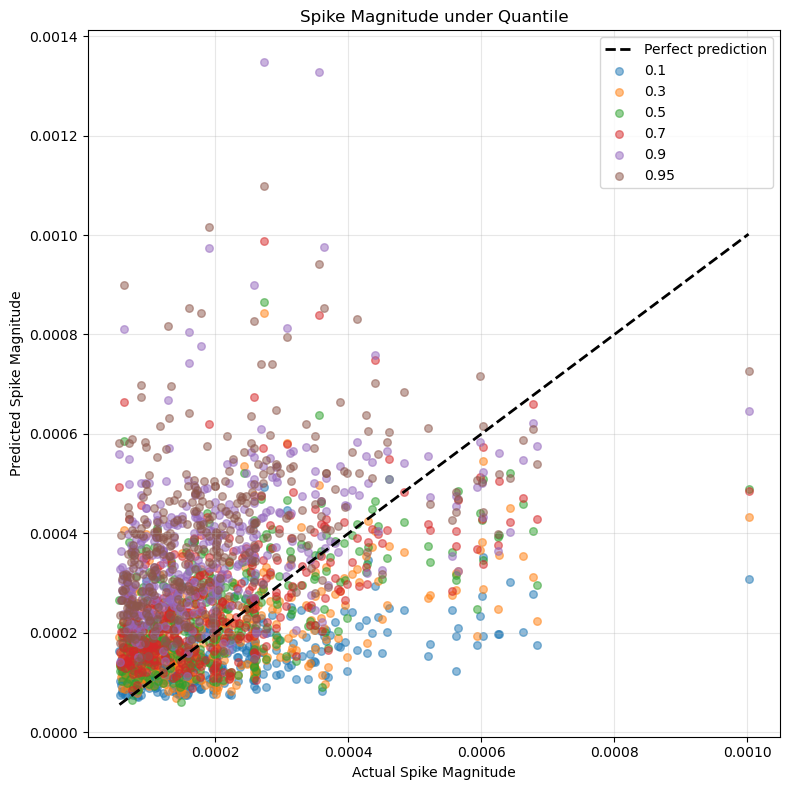

In [117]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

# Reference diagonal
min_y = pred_df["y_true"].min()
max_y = pred_df["y_true"].max()

plt.plot(
    [min_y, max_y],
    [min_y, max_y],
    linestyle="--",
    linewidth=2,
    color="black",
    label="Perfect prediction"
)

#QUANTILES = [0.5, 0.75, 0.9, 0.95]
columns = QUANTILES

# Plot each quantile
for q in columns:
    plt.scatter(
        pred_df["y_true"],
        pred_df[q],
        alpha=0.5,
        s=30,
        label=q
    )

plt.xlabel("Actual Spike Magnitude")
plt.ylabel("Predicted Spike Magnitude")
plt.title("Spike Magnitude under Quantile")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [97]:
import numpy as np

# sanity check
assert abs(sum(quantile_weights.values()) - 1.0) < 1e-6

weight_sum = sum(quantile_weights.values())
if not np.isclose(weight_sum, 1.0):
    raise ValueError(f"Quantile weights must sum to 1. Got {weight_sum}")

pred_df["expected_spike_given_spike"] = sum(
    w * pred_df[q] for q, w in quantile_weights.items()
)

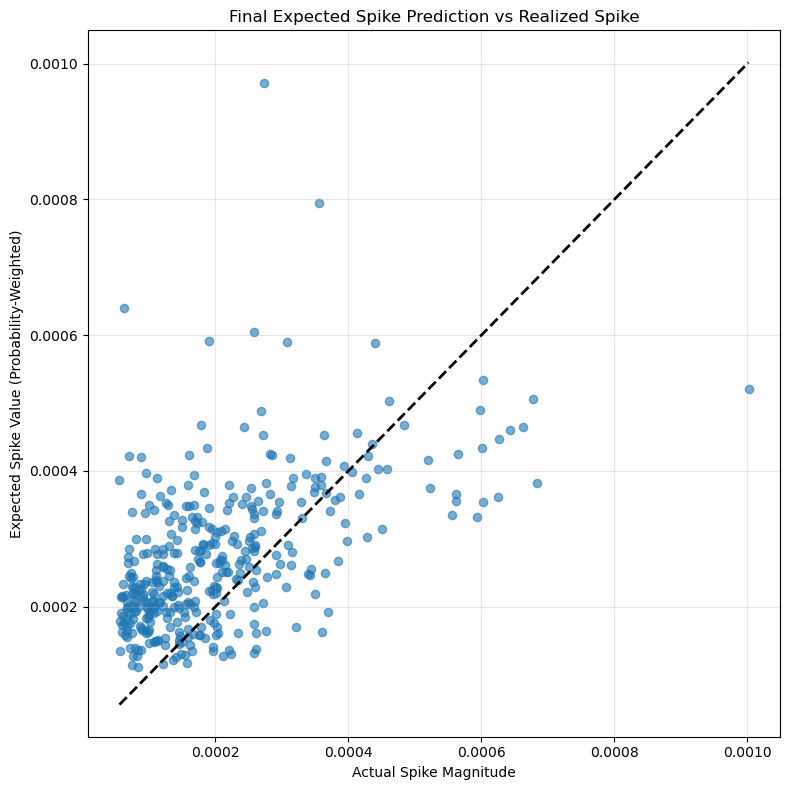

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

# Reference diagonal
min_y = min(
    pred_df["expected_spike_given_spike"].min(),
    pred_df["y_true"].min()
)
max_y = max(
    pred_df["expected_spike_given_spike"].max(),
    pred_df["y_true"].max()
)

plt.plot(
    [min_y, max_y],
    [min_y, max_y],
    linestyle="--",
    linewidth=2,
    color="black",
    label="Perfect prediction"
)

# Scatter plot
plt.scatter(
    pred_df["y_true"],
    pred_df["expected_spike_given_spike"],
    alpha=0.6,
    s=35
)

plt.xlabel("Actual Spike Magnitude")
plt.ylabel("Expected Spike Value (Probability-Weighted)")
plt.title("Final Expected Spike Prediction vs Realized Spike")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [99]:
mae = mean_absolute_error(pred_df["y_true"], pred_df["expected_spike_given_spike"])
print("MAE:", mae)

MAE: 0.00010679775288986616


In [118]:
import pandas as pd
from catboost import CatBoostRegressor

# =========================
# Quantile model factory (CatBoost)
# =========================
def train_quantile_model(X, y, quantile):
    model = CatBoostRegressor(
        loss_function=f"Quantile:alpha={quantile}",
        iterations=500,
        learning_rate=0.05,
        depth=6,
        subsample=0.8,
        random_seed=42,
        verbose=False
    )
    model.fit(X, y)
    return model

# =========================
# Quantiles & weights
# =========================
quantile_weights = {
    0.1: 0.05,
    0.3: 0.10,
    0.5: 0.35,
    0.7: 0.25,
    0.9: 0.15,
    0.95: 0.10
}

QUANTILES = quantile_weights.keys()

# =========================
# Train one model per quantile
# =========================
quantile_models = {}

for q in QUANTILES:
    print(f"Training CatBoost quantile model q={q}")
    quantile_models[q] = train_quantile_model(
        X_train,
        y_train,
        q
    )

# =========================
# Predict
# =========================
pred_dict = {}

for q, model in quantile_models.items():
    pred_dict[q] = model.predict(X_test)

pred_df = pd.DataFrame(pred_dict, index=y_test.index)
pred_df["y_true"] = y_test

print(pred_df.head())

Training CatBoost quantile model q=0.1
Training CatBoost quantile model q=0.3
Training CatBoost quantile model q=0.5
Training CatBoost quantile model q=0.7
Training CatBoost quantile model q=0.9
Training CatBoost quantile model q=0.95
                          0.1       0.3       0.5       0.7       0.9  \
timestamp                                                               
2023-11-15 16:00:00  0.000121  0.000181  0.000234  0.000271  0.000426   
2023-11-16 00:00:00  0.000117  0.000170  0.000164  0.000216  0.000403   
2023-11-16 08:00:00  0.000119  0.000185  0.000207  0.000240  0.000315   
2023-11-17 00:00:00  0.000109  0.000115  0.000127  0.000203  0.000319   
2023-11-18 00:00:00  0.000099  0.000097  0.000141  0.000178  0.000232   

                         0.95    y_true  
timestamp                                
2023-11-15 16:00:00  0.000502  0.000209  
2023-11-16 00:00:00  0.000326  0.000216  
2023-11-16 08:00:00  0.000355  0.000344  
2023-11-17 00:00:00  0.000428  0.000112  
2

In [119]:
from scipy.stats import spearmanr

for q in QUANTILES:
    rho, _ = spearmanr(pred_df["y_true"], pred_df[q])
    print(f"Spearman ρ ({q}): {rho:.3f}")

Spearman ρ (0.1): 0.140
Spearman ρ (0.3): 0.427
Spearman ρ (0.5): 0.460
Spearman ρ (0.7): 0.537
Spearman ρ (0.9): 0.554
Spearman ρ (0.95): 0.490


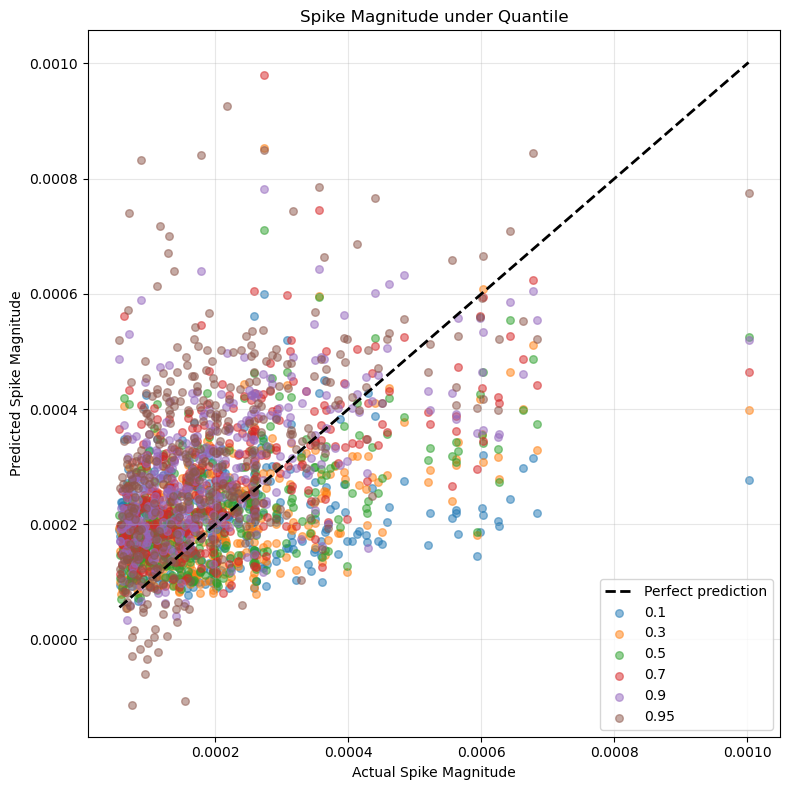

In [121]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

# Reference diagonal
min_y = pred_df["y_true"].min()
max_y = pred_df["y_true"].max()

plt.plot(
    [min_y, max_y],
    [min_y, max_y],
    linestyle="--",
    linewidth=2,
    color="black",
    label="Perfect prediction"
)

#QUANTILES = [0.5, 0.75, 0.9, 0.95]
columns = QUANTILES

# Plot each quantile
for q in columns:
    plt.scatter(
        pred_df["y_true"],
        pred_df[q],
        alpha=0.5,
        s=30,
        label=q
    )

plt.xlabel("Actual Spike Magnitude")
plt.ylabel("Predicted Spike Magnitude")
plt.title("Spike Magnitude under Quantile")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [122]:
import numpy as np

# sanity check
assert abs(sum(quantile_weights.values()) - 1.0) < 1e-6

weight_sum = sum(quantile_weights.values())
if not np.isclose(weight_sum, 1.0):
    raise ValueError(f"Quantile weights must sum to 1. Got {weight_sum}")

pred_df["expected_spike_given_spike"] = sum(
    w * pred_df[q] for q, w in quantile_weights.items()
)

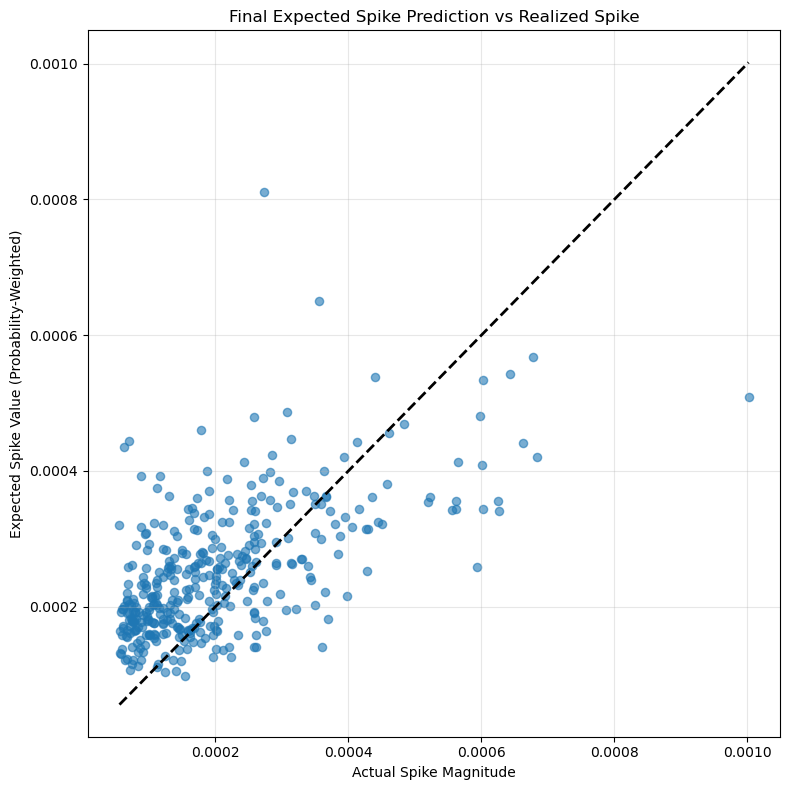

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

# Reference diagonal
min_y = min(
    pred_df["expected_spike_given_spike"].min(),
    pred_df["y_true"].min()
)
max_y = max(
    pred_df["expected_spike_given_spike"].max(),
    pred_df["y_true"].max()
)

plt.plot(
    [min_y, max_y],
    [min_y, max_y],
    linestyle="--",
    linewidth=2,
    color="black",
    label="Perfect prediction"
)

# Scatter plot
plt.scatter(
    pred_df["y_true"],
    pred_df["expected_spike_given_spike"],
    alpha=0.6,
    s=35
)

plt.xlabel("Actual Spike Magnitude")
plt.ylabel("Expected Spike Value (Probability-Weighted)")
plt.title("Final Expected Spike Prediction vs Realized Spike")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
mae = mean_absolute_error(y_test, preds)
print("MAE:", mae)